Collecting climate-related data from Reddit and Twitter and applying an LDA Topic Model for analysis as a baseline ([Documentation](https://www.overleaf.com/read/hggynfmcqncf#01a42f)).



*   gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.2 which is incompatible.
*   gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.16.1 which is incompatible.



# Preprocessing

In [ ]:
import pandas as pd
!pip install numpy==1.23.5 gensim==4.3.3
import numpy as np

import re, os, sys, json, csv, copy
from collections import Counter
import joblib # saving/loading models
import time # start, stop times

import warnings
warnings.filterwarnings('ignore')

### Topic modeling, preprocessing, etc.
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer # lemmatization function

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.cluster import AgglomerativeClustering # clustering and hierarchy

import gensim
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel # model performance
from gensim.matutils import jaccard
from gensim.matutils import jensen_shannon

### Visualizations
!pip install pyLDAvis
import pyLDAvis # notebooks
from pyLDAvis import gensim as pyldagensim # communicate with gensim
import pyLDAvis.lda_model # communicate with sklearn

import matplotlib.pyplot as plt # general plotting
from scipy.cluster.hierarchy import linkage, dendrogram # hierarchy
import seaborn as sns # heatmaps

# add scripts directory to path
sys.path.insert(1, '../scripts/')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/KHP/Results/'
reddit_df = pd.read_csv(os.path.join(folder_path, 'Climate_Reddit_Youth_Sentiment_Emotion_Labelled.csv'))
twitter_df = pd.read_csv(os.path.join(folder_path, 'Climate_Tweet_Youth_Sentiment_Emotion_Labelled.csv'))

print(f"Reddit dataframe with {len(reddit_df)} entries: \n{reddit_df.head()}")
print(f"\n Twitter dataframe with {len(twitter_df)} entries: \n{twitter_df.head()}")

Mounted at /content/drive
Reddit dataframe with 22694 entries: 
                                                text   score  youth_proba  \
0  we re doing exacy y what greta told us not to ...  1844.0     0.997069   
1    yeii! peru banned palm oil deforestation! <url>  1386.0     0.690106   
2                                  interesting <url>  1364.0     0.988409   
3  bolivia is currently protesting its president ...  1326.0     0.850783   
4                                 go greta go! <url>  1315.0     0.871475   

  sentiment_label  sentiment_proba emotion_label  emotion_proba  
0             NEU         0.759771       neutral       0.836867  
1             POS         0.771204       neutral       0.841856  
2             POS         0.655973    admiration       0.216559  
3             NEU         0.453050    admiration       0.725970  
4             POS         0.922679       neutral       0.960510  

 Twitter dataframe with 20835 entries: 
                                    

**Functions**

In [ ]:
# checks if strings (s) contain only English characters
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True # if all characters are in english

# Removing/replacing non-English characters
def fix_text(txt):
    if not isEnglish(txt):
        for i, s in enumerate(txt):
            if not isEnglish(s):
                if len(txt)>=i+2:
                    if txt[i+1] == 's':
                        txt = txt.replace(s,"'")
                    elif txt[i+1] == ' ' and "'" not in txt:
                        txt = txt.replace(s,'-')
                    else:
                        txt = txt.replace(s,'')
                else:
                    txt = txt.replace(s,'')
    return txt

def get_jensen_shannon(components, ntopics):
    topic_dists = components
    js_dists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i>j:
                js_dists.append(jensen_shannon(topic_dists[i,:], topic_dists[j,:]))

    return np.min(js_dists), np.mean(js_dists)

def get_jaccard(components, ntopics): # not being used
    topn = int(np.ceil(len(dictionary)*(10/100)))
    topic_word_probs = components
    top_terms = np.argsort(-1*topic_word_probs,axis=1)
    top_terms = 1*top_terms[:,0:topn]
    jdists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i > j:
                jdists.append(jaccard(top_terms[i,:], top_terms[j,:]))
    return np.min(jdists), np.mean(jdists)

class LDAwithCustomScore(LatentDirichletAllocation):
    def score(self, X, y=None):
        components = self.components_
        ntopics = self.n_components
        score = get_jensen_shannon(components, ntopics)[0]
        return score

In [ ]:
stopwords = list(gensim.parsing.preprocessing.STOPWORDS)


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# List of stopwords in English
stopwords = list(ENGLISH_STOP_WORDS)


additional_stopwords = [
    # platform-specific
    'rt', 'tweet', 'repost', 'replied', 'comments', 'comment', 'upvote', 'downvote', 'subreddit',
    'thread', 'user', 'followers', 'post', 'share', 'like', 'reply', 'hashtag', 'hashtags',
    'link', 'bio', 'mention', 'tagged', 'followed', 'following', 'message', 'profile',

    # filler and vague
    'literally', 'actually', 'kinda', 'totally', 'idk', 'btw', 'omg', 'lol', 'lmao',
    'you know', 'basically', 'seriously', 'honestly', 'obviously', 'probably', 'idc',
    'maybe', 'exactly', 'apparently', 'definitely', 'pretty', 'thing', 'stuff',
    'I mean', 'uh', 'um', 'err', 'ah', 'yeah', 'okay', 'gotcha', 'bruh', 'bro',
    'yup', 'nope', 'nah', 'wait', 'pretty much', 'as if', 'thank you', 'thanks',
    'for sure', 'in fact', 'kind of', 'sort of', 'at least', 'like I said', 'at the end of the day',

    # common, redundant
    'it is', 'there is', 'there are', 'that’s', 'this is', 'the thing', 'of course', 'at the moment',
    'you know what I mean', 'don’t know', 'do you know', 'all the time', 'just saying', 'honestly speaking',
    'the truth is', 'somebody', 'situation', 'matter', 'fact', 'time', 'point', 'problem', 'issue', 'question',
    'extremely', 'super', 'highly', 'completely', 'entirely',

    # found after initial topic modeling
    'think', 'talk', 'look', 'tell', 'happen', 'increase', 'years', 'people', 'sure',
    'know', 'come', 'today', 'year', 'earth', 'world',
]
climate_terms = ['climate', 'change', 'climate change', 'global warming'] # expected & might dominate (sub)topics
profanities = ['fuck', 'shit', 'ass'] # emotional but might introduce noise

for word in additional_stopwords + climate_terms + profanities:
  if word not in stopwords:
    stopwords.append(word)

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(text, pos='v')

# Tokenize and lemmatize
def preprocess(text, stopwords):
    result = []
    stem_dict = []

    text = fix_text(text)  # Fix text first
    tokens = gensim.utils.simple_preprocess(text)

    for token in tokens:
        if token not in stopwords:
            lemmatized_token = lemmatize(token)
            if lemmatized_token not in stopwords and len(lemmatized_token) > 3:
                result.append(lemmatized_token)
                stem_dict.append((lemmatized_token, token))

    return result, stem_dict

# Topic Modeling

Selecting & evaluating the best model

In [ ]:
def best_model(documents, ntopics_list):
    processed_info = []
    for allinfo in documents['text'].values:
        preprocessed, stemdict = preprocess(allinfo, stopwords)
        processed_info.append(preprocessed)

    countvec = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=.25, min_df=10)
    clean_text = [' '.join(text) for text in processed_info]
    X = countvec.fit_transform(clean_text).toarray()
    wft = np.sum(X, axis=0).T

    terms = countvec.get_feature_names_out()

    # Using grid search CV with pipeline to find the best model
    search_params = {'n_components': ntopics_list}
    lda = LDAwithCustomScore(random_state=0)
    model = GridSearchCV(lda, param_grid=search_params, cv=5)
    model.fit(X)

    return model.best_estimator_, processed_info, X, terms, countvec # return the best model

def Evaluate(model, processed_info, X, terms):
  topic_word_distributions = model.components_  # how often the top words in a topic appear together in documents
  top_n_words = 10
  topics = [[terms[i] for i in topic.argsort()[:-top_n_words - 1:-1]] for topic in topic_word_distributions]

  dictionary = gensim.corpora.Dictionary(processed_info)
  coherence_model = CoherenceModel(topics=topics, texts=processed_info,
                                   dictionary=dictionary, coherence='c_v')
  coherence_score = coherence_model.get_coherence()

  print(f'Coherence Score: {coherence_score}')

  perplexity = model.perplexity(X)  # how well the model generalizes to unseen data, lower is better
  print(f'Perplexity: {perplexity}')

  topic_distribution = model.transform(X) # transform the document-term matrix into topic distributions

  return coherence_score, perplexity, topic_distribution

Visualizations & Clustering

In [ ]:
def visualize_topics(model, topic_distribution, X, countvec):
    topic_term_dists = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    doc_lengths = X.sum(axis=1).tolist()
    term_frequency = np.asarray(X.sum(axis=0)).flatten().tolist()
    vocab = countvec.get_feature_names_out()

    data = pyLDAvis.prepare(
        topic_term_dists,  # topic-word distributions
        topic_distribution,   # document-topic distributions
        doc_lengths,       # total word count per document
        vocab,             # list of terms/features
        term_frequency     # sum of word counts for each term
    )

    return data

sys.setrecursionlimit(10000)
names = ['Reddit', 'Twitter']
def hierarchy(model, topic_distribution, dataset_name, n_clusters=None, distance_threshold=0, linkage_method='ward', figsize=(50, 35)):
    """
    - distance_threshold (float): threshold for the clustering, a positive value ensures a proper cutoff.
    - linkage_method (str): The linkage method for the dendrogram plot.
    - figsize (tuple): The size of the figure for the dendrogram.
    """
    # AgglomerativeClustering model
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold)
    agg_clustering.fit(topic_distribution)

    children = agg_clustering.children_ # Create a linkage matrix using children_
    n_samples = len(topic_distribution)
    linkage_matrix = np.zeros((n_samples - 1, 4)) # empty linkage matrix

    for i, (left, right) in enumerate(children):
        # The left and right indices are zero-based, so add 1 for the correct format
        linkage_matrix[i, 0] = left
        linkage_matrix[i, 1] = right
        linkage_matrix[i, 2] = agg_clustering.distances_[i]  # distance between merged clusters
        linkage_matrix[i, 3] = 2  # number of elements in the new cluster (2 clusters merged)

    plt.figure(figsize=figsize)
    dendrogram(linkage_matrix, labels=[f"Doc {i+1}" for i in range(n_samples)])  # creating a dendrogram
    plt.title(f'{dataset_name} Hierarchical Clustering')
    plt.xlabel('Documents')
    plt.ylabel('Distance')
    plt.show()

    return agg_clustering

Reddit

In [ ]:
start_time = time.time()
best_reddit_model, processed_info, X_reddit, reddit_terms, reddit_countvec = best_model(reddit_df, ntopics_list=[5, 15, 50, 75, 100, 150])
end_time = time.time()

reddit_training_time = end_time - start_time

print(f"The best Reddit LDA model has {best_reddit_model.n_components} distinct topics")
print(f"Training time: {reddit_training_time:.4f} seconds (with GridSearch)\n")

redditLDA_model_path = '/content/drive/My Drive/Notebooks/LDA Topic Modeling/LDA_reddit_model.pkl'
joblib.dump(best_reddit_model, redditLDA_model_path)  # saving the model

reddit_coherence_score, reddit_perplexity, reddit_topic_distribution = Evaluate(best_reddit_model, processed_info, X_reddit, reddit_terms)

The best Reddit LDA model has 75 distinct topics
Training time: 476.2049 seconds (with GridSearch)

Coherence Score: 0.38391207550160794
Perplexity: 2874.7201735870167


In [ ]:
import joblib, sys
import sklearn
!pip install pyLDAvis
import pyLDAvis # notebooks
from pyLDAvis import gensim as pyldagensim # communicate with gensim
import pyLDAvis.lda_model # communicate with sklearn
# add scripts directory to path
sys.path.insert(1, '../scripts/')

from google.colab import drive
drive.mount('/content/drive')

best_reddit_model = joblib.load('/content/drive/My Drive/Notebooks/LDA Topic Modeling/Models/LDA_reddit_model.pkl')

Mounted at /content/drive


AttributeError: Can't get attribute 'LDAwithCustomScore' on <module '__main__'>

In [ ]:
reddit_data = visualize_topics(best_reddit_model, reddit_topic_distribution, X_reddit, reddit_countvec)

pyLDAvis.enable_notebook()
pyLDAvis.display(reddit_data)

reddit_vis_path = '/content/drive/My Drive/Notebooks/LDA Topic Modeling/Models/Reddit_pyLDAvis.html'
pyLDAvis.save_html(reddit_data, reddit_vis_path)

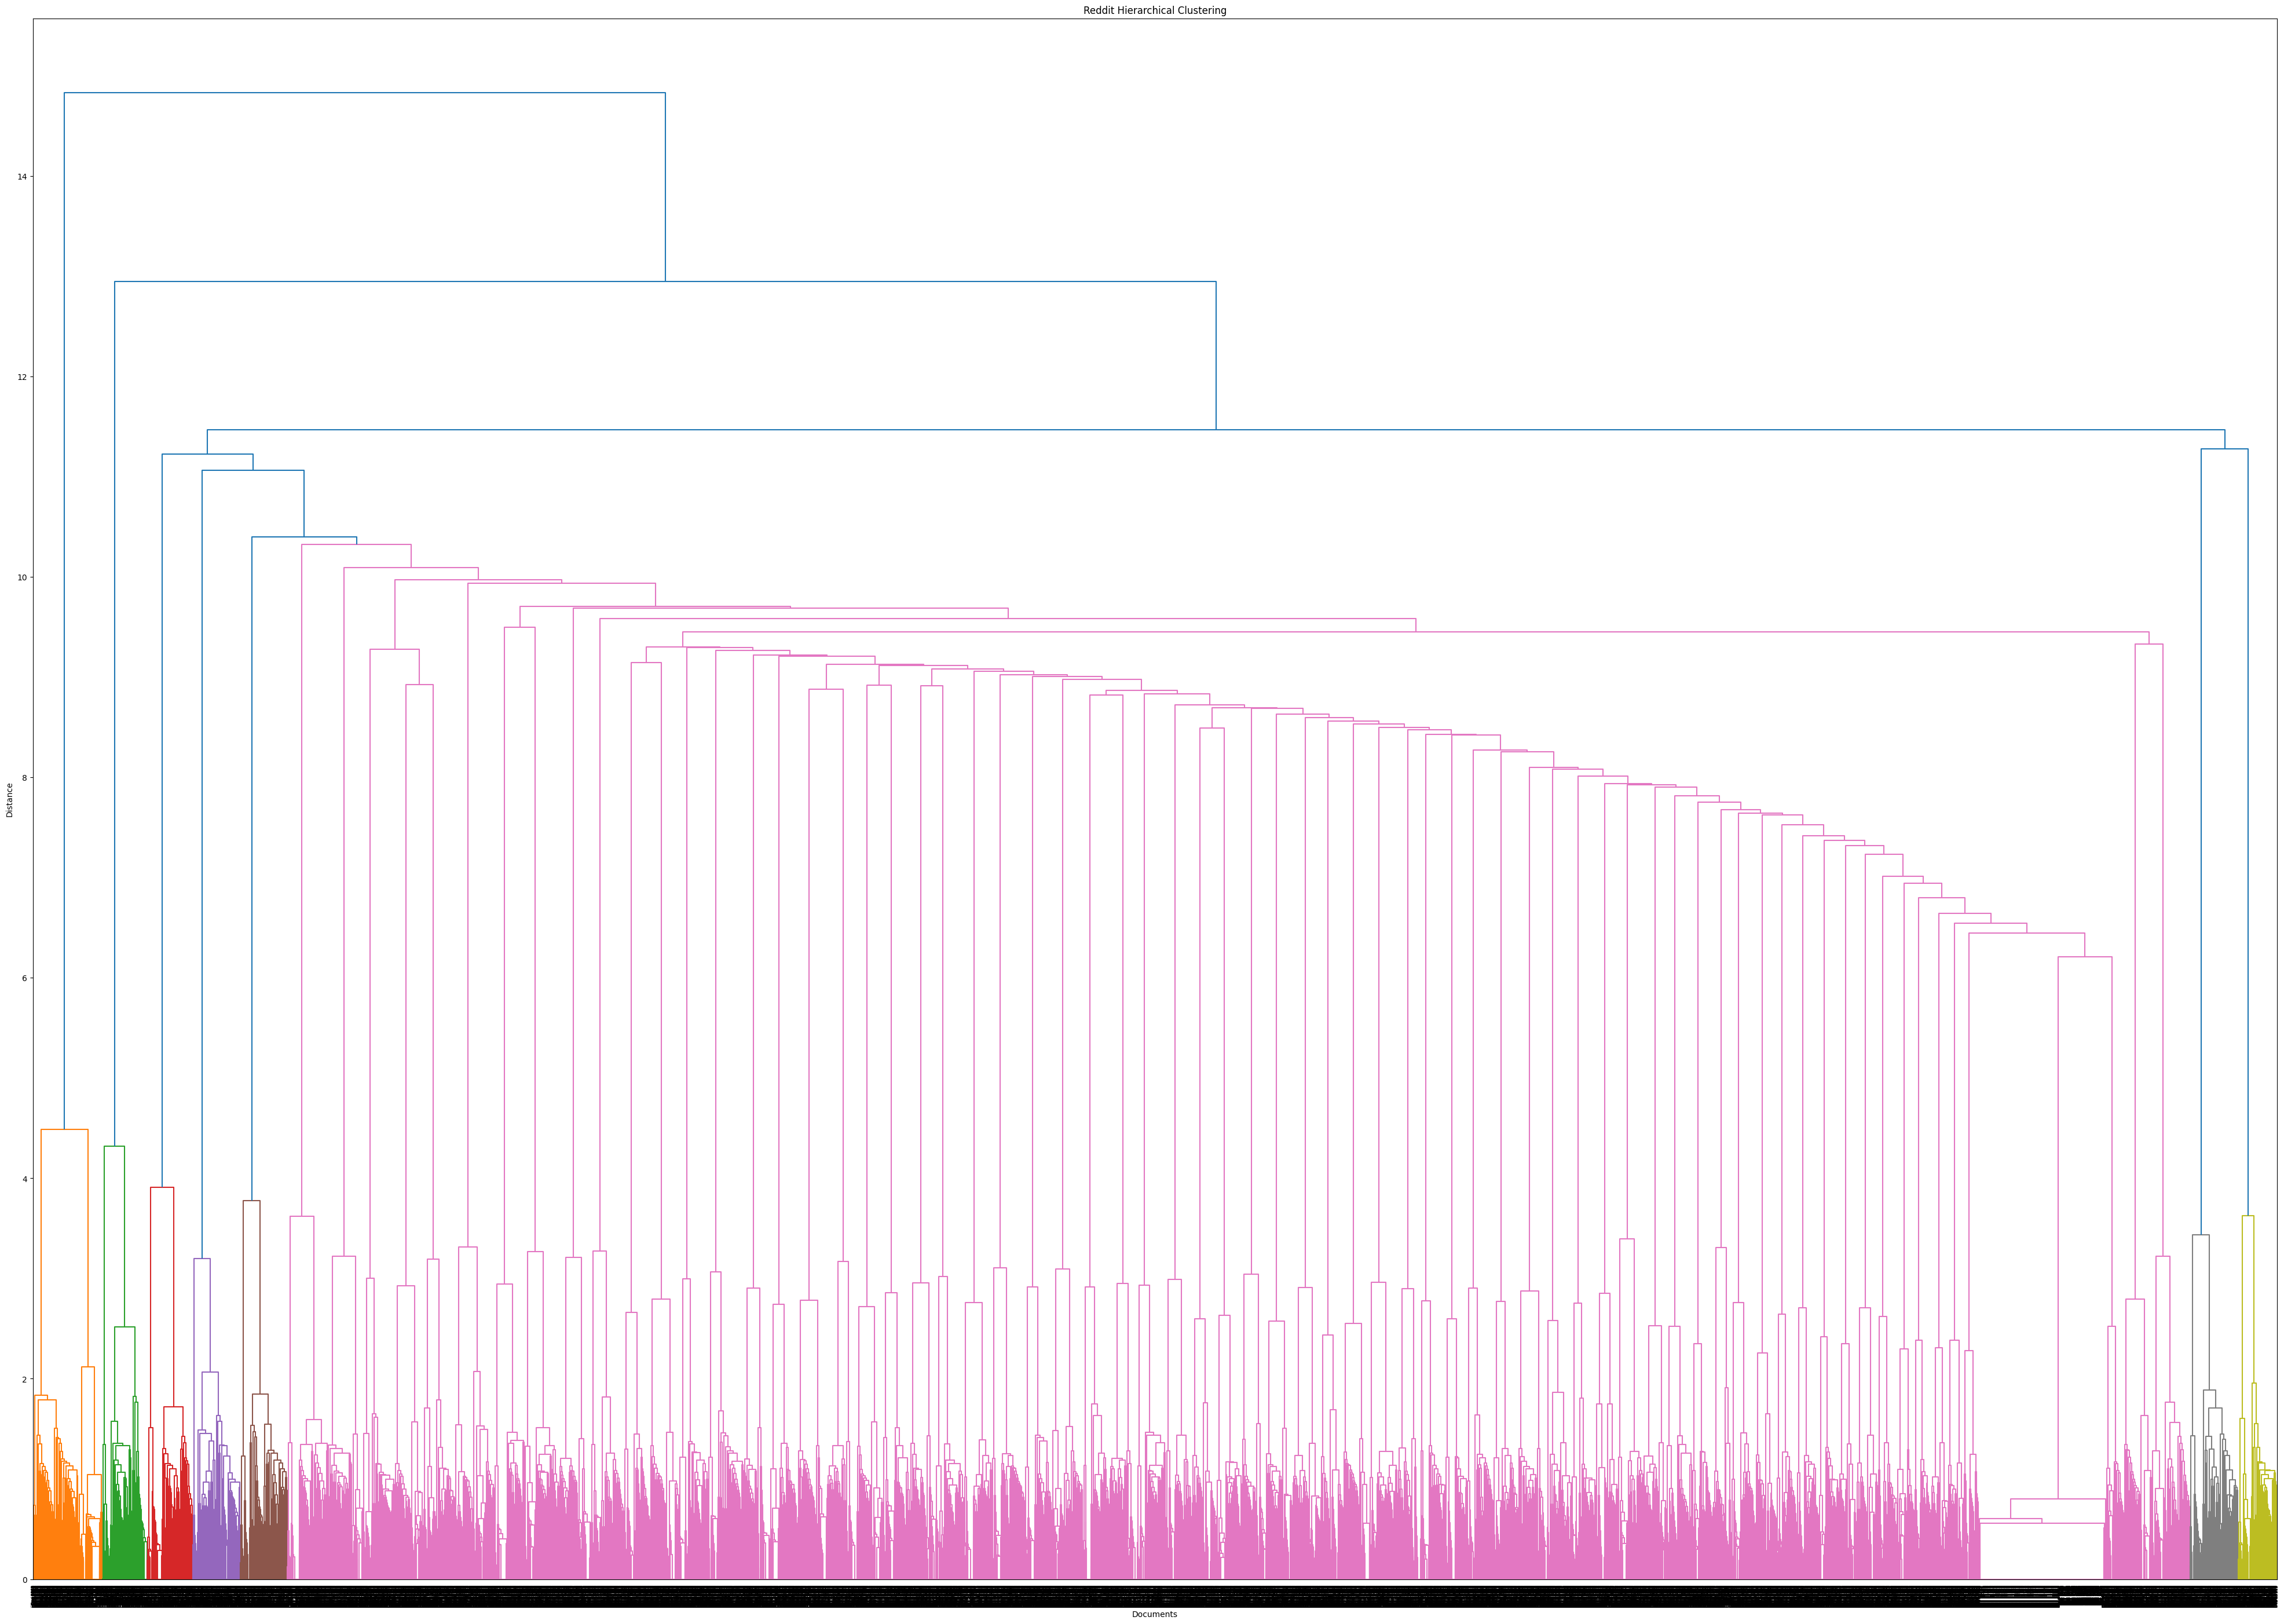

In [ ]:
# Call the function to perform clustering and generate the dendrogram
agg_clustering_model_reddit = hierarchy(best_reddit_model, reddit_topic_distribution, dataset_name=names[0], n_clusters=None, distance_threshold=0.0)
#print(agg_clustering_model_reddit.labels_)

Twitter

In [ ]:
start_time = time.time()
best_twitter_model, processed_info, X_twitter, twitter_terms, twitter_countvec = best_model(twitter_df, ntopics_list=[5, 15, 50, 75, 100, 150])
end_time = time.time()

twitter_training_time = end_time - start_time

print(f"The best Twitter LDA model has {best_twitter_model.n_components} distinct topics")
print(f"Training time: {twitter_training_time:.4f} seconds (with GridSearch)\n")

twitterLDA_model_path = '/content/drive/My Drive/Notebooks/LDA Topic Modeling/LDA_twitter_model.pkl'
joblib.dump(best_twitter_model, twitterLDA_model_path) # saving the model

# Call Evaluate with the necessary arguments
twitter_coherence_score, twitter_perplexity, twitter_topic_distribution = Evaluate(best_twitter_model, processed_info, X_twitter, twitter_terms)

The best Twitter LDA model has 100 distinct topics
Training time: 482.4193 seconds (with GridSearch)

Coherence Score: 0.4316963076809774
Perplexity: 1865.3585784239972


In [ ]:
best_twitter_model = joblib.load('/content/drive/My Drive/Notebooks/LDA Topic Modeling/LDA_twitter_model.pkl')

In [ ]:
twitter_data = visualize_topics(best_twitter_model, twitter_topic_distribution, X_twitter, twitter_countvec)

pyLDAvis.enable_notebook()
pyLDAvis.display(twitter_data)

twitter_vis_path = '/content/drive/My Drive/Notebooks/LDA Topic Modeling/Models/Twitter_pyLDAvis.html'
pyLDAvis.save_html(twitter_data, twitter_vis_path)

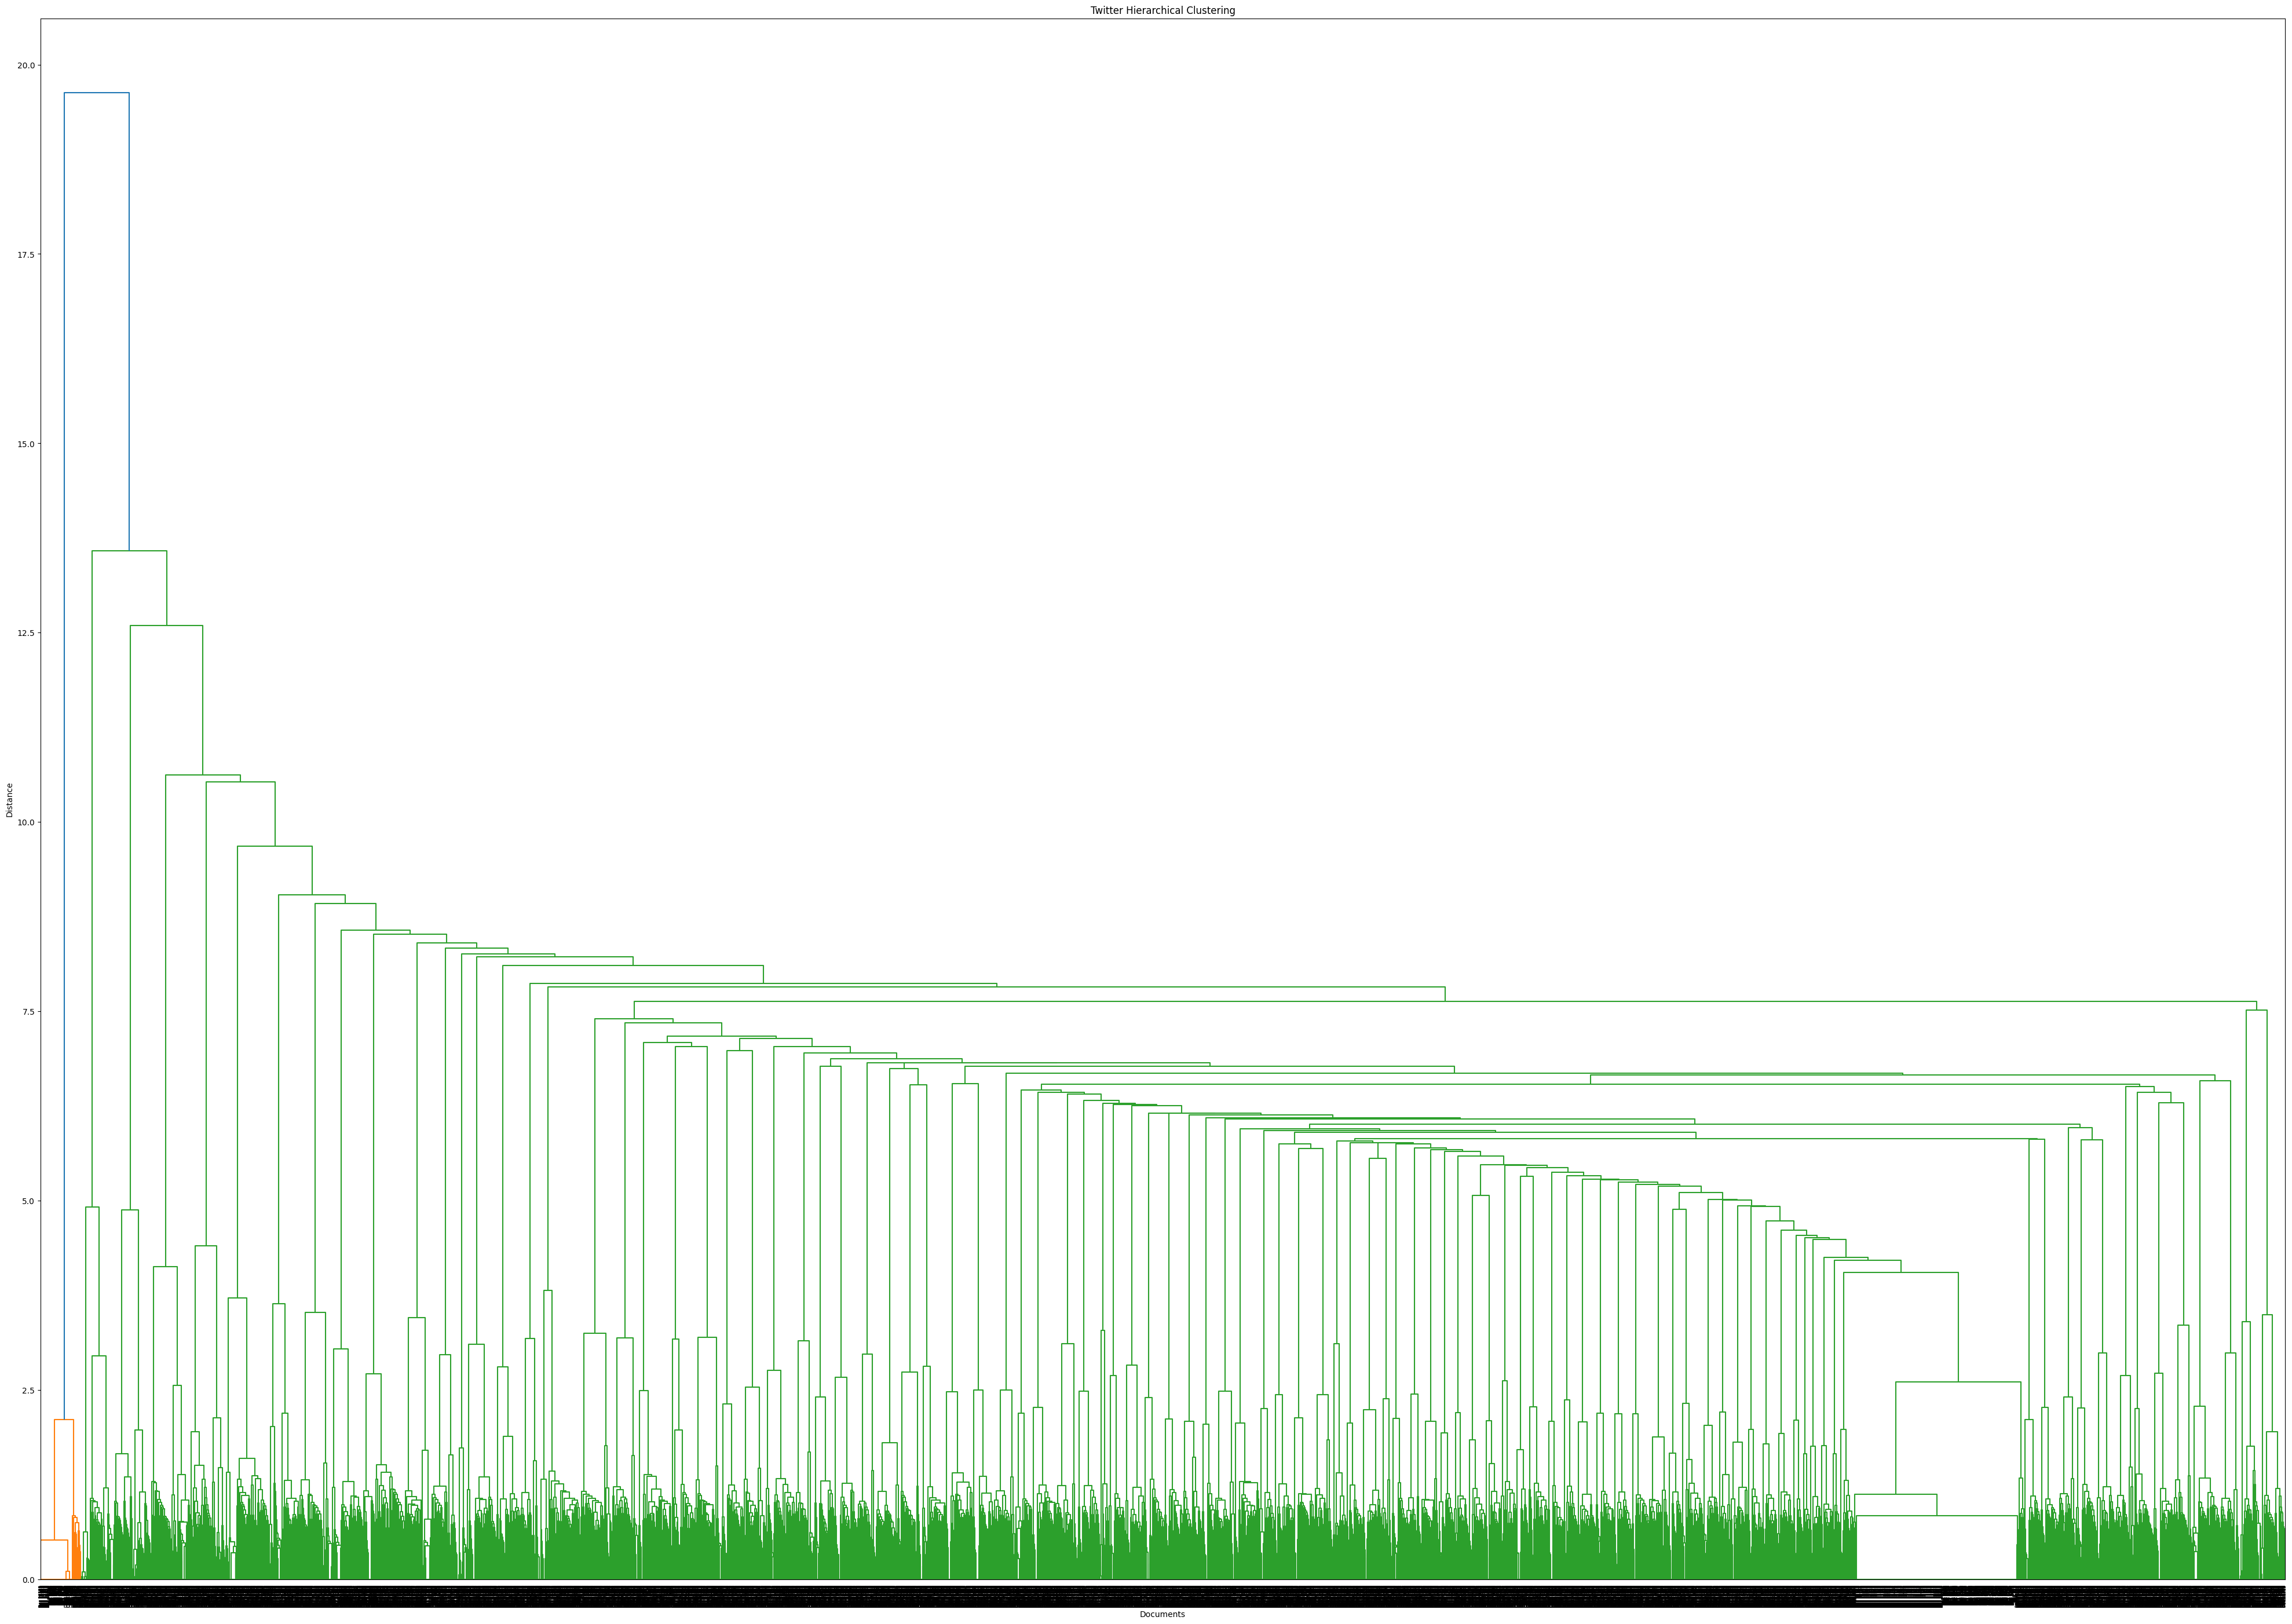

In [ ]:
agg_clustering_model_twitter = hierarchy(best_twitter_model, twitter_topic_distribution, dataset_name=names[1], n_clusters=None, distance_threshold=0.0)
#print(agg_clustering_model_twitter.labels_)

# Visualizations

In [ ]:
pip install gensim

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
pip install numpy==1.18.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import gensim

def get_jensen_shannon(components, ntopics):
    topic_dists = components
    js_dists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i>j:
                js_dists.append(jensen_shannon(topic_dists[i,:], topic_dists[j,:]))

    return np.min(js_dists), np.mean(js_dists)

class LDAwithCustomScore(LatentDirichletAllocation):
    def score(self, X, y=None):
        components = self.components_
        ntopics = self.n_components
        score = get_jensen_shannon(components, ntopics)[0]
        return score

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import pandas as pd
import numpy as np

import re, os, sys, json, csv, copy
from collections import Counter
import joblib # saving/loading models
import time # start, stop times

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.cluster import AgglomerativeClustering # clustering and hierarchy

import matplotlib.pyplot as plt # general plotting
from scipy.cluster.hierarchy import linkage, dendrogram # hierarchy
import seaborn as sns # heatmaps

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/KHP/Results/'
reddit_df = pd.read_csv(os.path.join(folder_path, 'Climate_Reddit_Youth_Sentiment_Emotion_Labelled.csv'))
twitter_df = pd.read_csv(os.path.join(folder_path, 'Climate_Tweet_Youth_Sentiment_Emotion_Labelled.csv'))

names = ['Reddit', 'Twitter']

best_reddit_model = joblib.load('/content/drive/My Drive/Notebooks/LDA Topic Modeling/Models/LDA_reddit_model.pkl')
best_twitter_model = joblib.load('/content/drive/My Drive/Notebooks/LDA Topic Modeling/LDA_twitter_model.pkl')

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer # refitting if needed

stopwords = list(ENGLISH_STOP_WORDS)
custom_stopwords = []
additional_stopwords = [
    'rt', 'tweet', 'repost', 'replied', 'comments', 'comment', 'upvote', 'downvote', 'subreddit',
    'thread', 'user', 'followers', 'post', 'share', 'like', 'reply', 'hashtag', 'hashtags',
    'link', 'bio', 'mention', 'tagged', 'followed', 'following', 'message', 'profile',
    'literally', 'actually', 'kinda', 'totally', 'idk', 'btw', 'omg', 'lol', 'lmao', 'you know',
    'basically', 'seriously', 'honestly', 'obviously', 'probably', 'idc', 'maybe', 'exactly',
    'apparently', 'definitely', 'pretty', 'thing', 'stuff', 'I mean', 'uh', 'um', 'err', 'ah',
    'yeah', 'okay', 'gotcha', 'bruh', 'bro', 'yup', 'nope', 'nah', 'wait', 'thanks',
    "that’s", "don’t", 'know', 'you', 'somebody', 'situation', 'matter', 'fact', 'time', 'point',
    'problem', 'issue', 'question', 'extremely', 'super', 'highly', 'completely', 'entirely', 'much',
]

climate_terms = ['climate', 'change', 'climate ', 'change ', 'global', 'warming']
profanities = ['fuck', 'fucking', 'fuckin', 'shit', 'ass']

found_after = [
    'thank', 'love', 'look', 'join', 'read', 'year', 'years', 'number',
    'ago', 'yadda', 'deterraforme', 'tldr', 'paywall', 'paywalle', 'automod', 'version', 'unlocked',
    'banger', 'wear', 'sock', 'rookie', 'add', 'list', 'boiling', 'pipe', 'retweet', 'pass', 'log',
    'general', 'friday', 'monday', 'late', 'use', 'eat', 'green', 'orange', 'apple', 'blah', 'think',
    'don', 'predict', 'feedback', 'solve', 'people', 'greta', 'thunberg', 'good', 'cool',
    'great', 'wow', 'ida', 'amp', 'science', 'vote', 'billion', 'trillion', 'liar', 'murdoch',
    'francis', 'joe', 'biden', 'go', 'manchin', 'mitch', 'mcconnell', 'talk', 'say', 'bad', 'new',
    'york', 'brexshit', 'babygo', 'hot', 'warm', 'kid', 'baby', 'son', 'daughter', 'girl', 'boy',
    'take', 'stop', 'philmurphy', 'phil', 'murphy', 'airplane', 'come', 'ready', 'pull', 'bla',
    'miss', 'intl', 'grand', 'end', 'endthefilibusternow', 'filibuster', 'cold',
    'click', 'ratchet', 'conf', 'read', 'know', 'dark', 'day', 'recycling', 'fairly',
    'take', 'ankle', 'mackenzie', 'buy', 'teen', 'post', 'dlp', 'beckwith', 'steinberger',
    'click', 'sgk',
]

custom_stopwords = additional_stopwords + climate_terms + profanities + found_after

for word in custom_stopwords:
  stopwords.append(word)

reddit_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=0.25, min_df=10)
reddit_X = reddit_vectorizer.fit_transform(reddit_df)
reddit_terms = reddit_vectorizer.get_feature_names_out()

twitter_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=0.25, min_df=10)
twitter_X = twitter_vectorizer.fit_transform(twitter_df)
twitter_terms = twitter_vectorizer.get_feature_names_out()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AttributeError: Can't get attribute 'LDAwithCustomScore' on <module '__main__'>

In [ ]:
def plot_topic_word_distributions(model, terms, dataset_name, top_n=1):
    topic_word_distributions = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topics = np.argsort(-topic_word_distributions, axis=1)[:, :top_n]

    data = np.zeros((len(topics), top_n))
    for i, topic in enumerate(topics):
        data[i] = topic_word_distributions[i, topic]

    fig, ax = plt.subplots(figsize=(15, 30))  # adjust size
    ax.barh(range(len(topics)), data.sum(axis=1), color='gray', alpha=0.5)

    colors = plt.cm.get_cmap('tab20', len(topics))  # color map for different topics

    for i, topic in enumerate(topics):
        ax.barh(i, data[i], color=colors(i))
        words = ', '.join([terms[j] for j in topic])
        value = data[i].sum()
        ax.text(value + 0.01, i, words, va='center', fontsize=10, color='black')

    ax.set_title(f'{dataset_name} Topic Word Distribution')
    ax.set_yticks(range(len(topics)))
    ax.set_yticklabels([f'Topic {i+1}' for i in range(len(topics))])

    plt.xlabel('Word Distribution')
    plt.tight_layout()
    plt.show()

plot_topic_word_distributions(best_reddit_model, reddit_terms, dataset_name=names[0], top_n=1)
plot_topic_word_distributions(best_twitter_model, twitter_terms, dataset_name=names[1], top_n=1)

Topic Word Distribution Comparison (Stacked Bar Plot)

<ipython-input-76-3fbe8846d701>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(topics))  # Use a color map for different topics


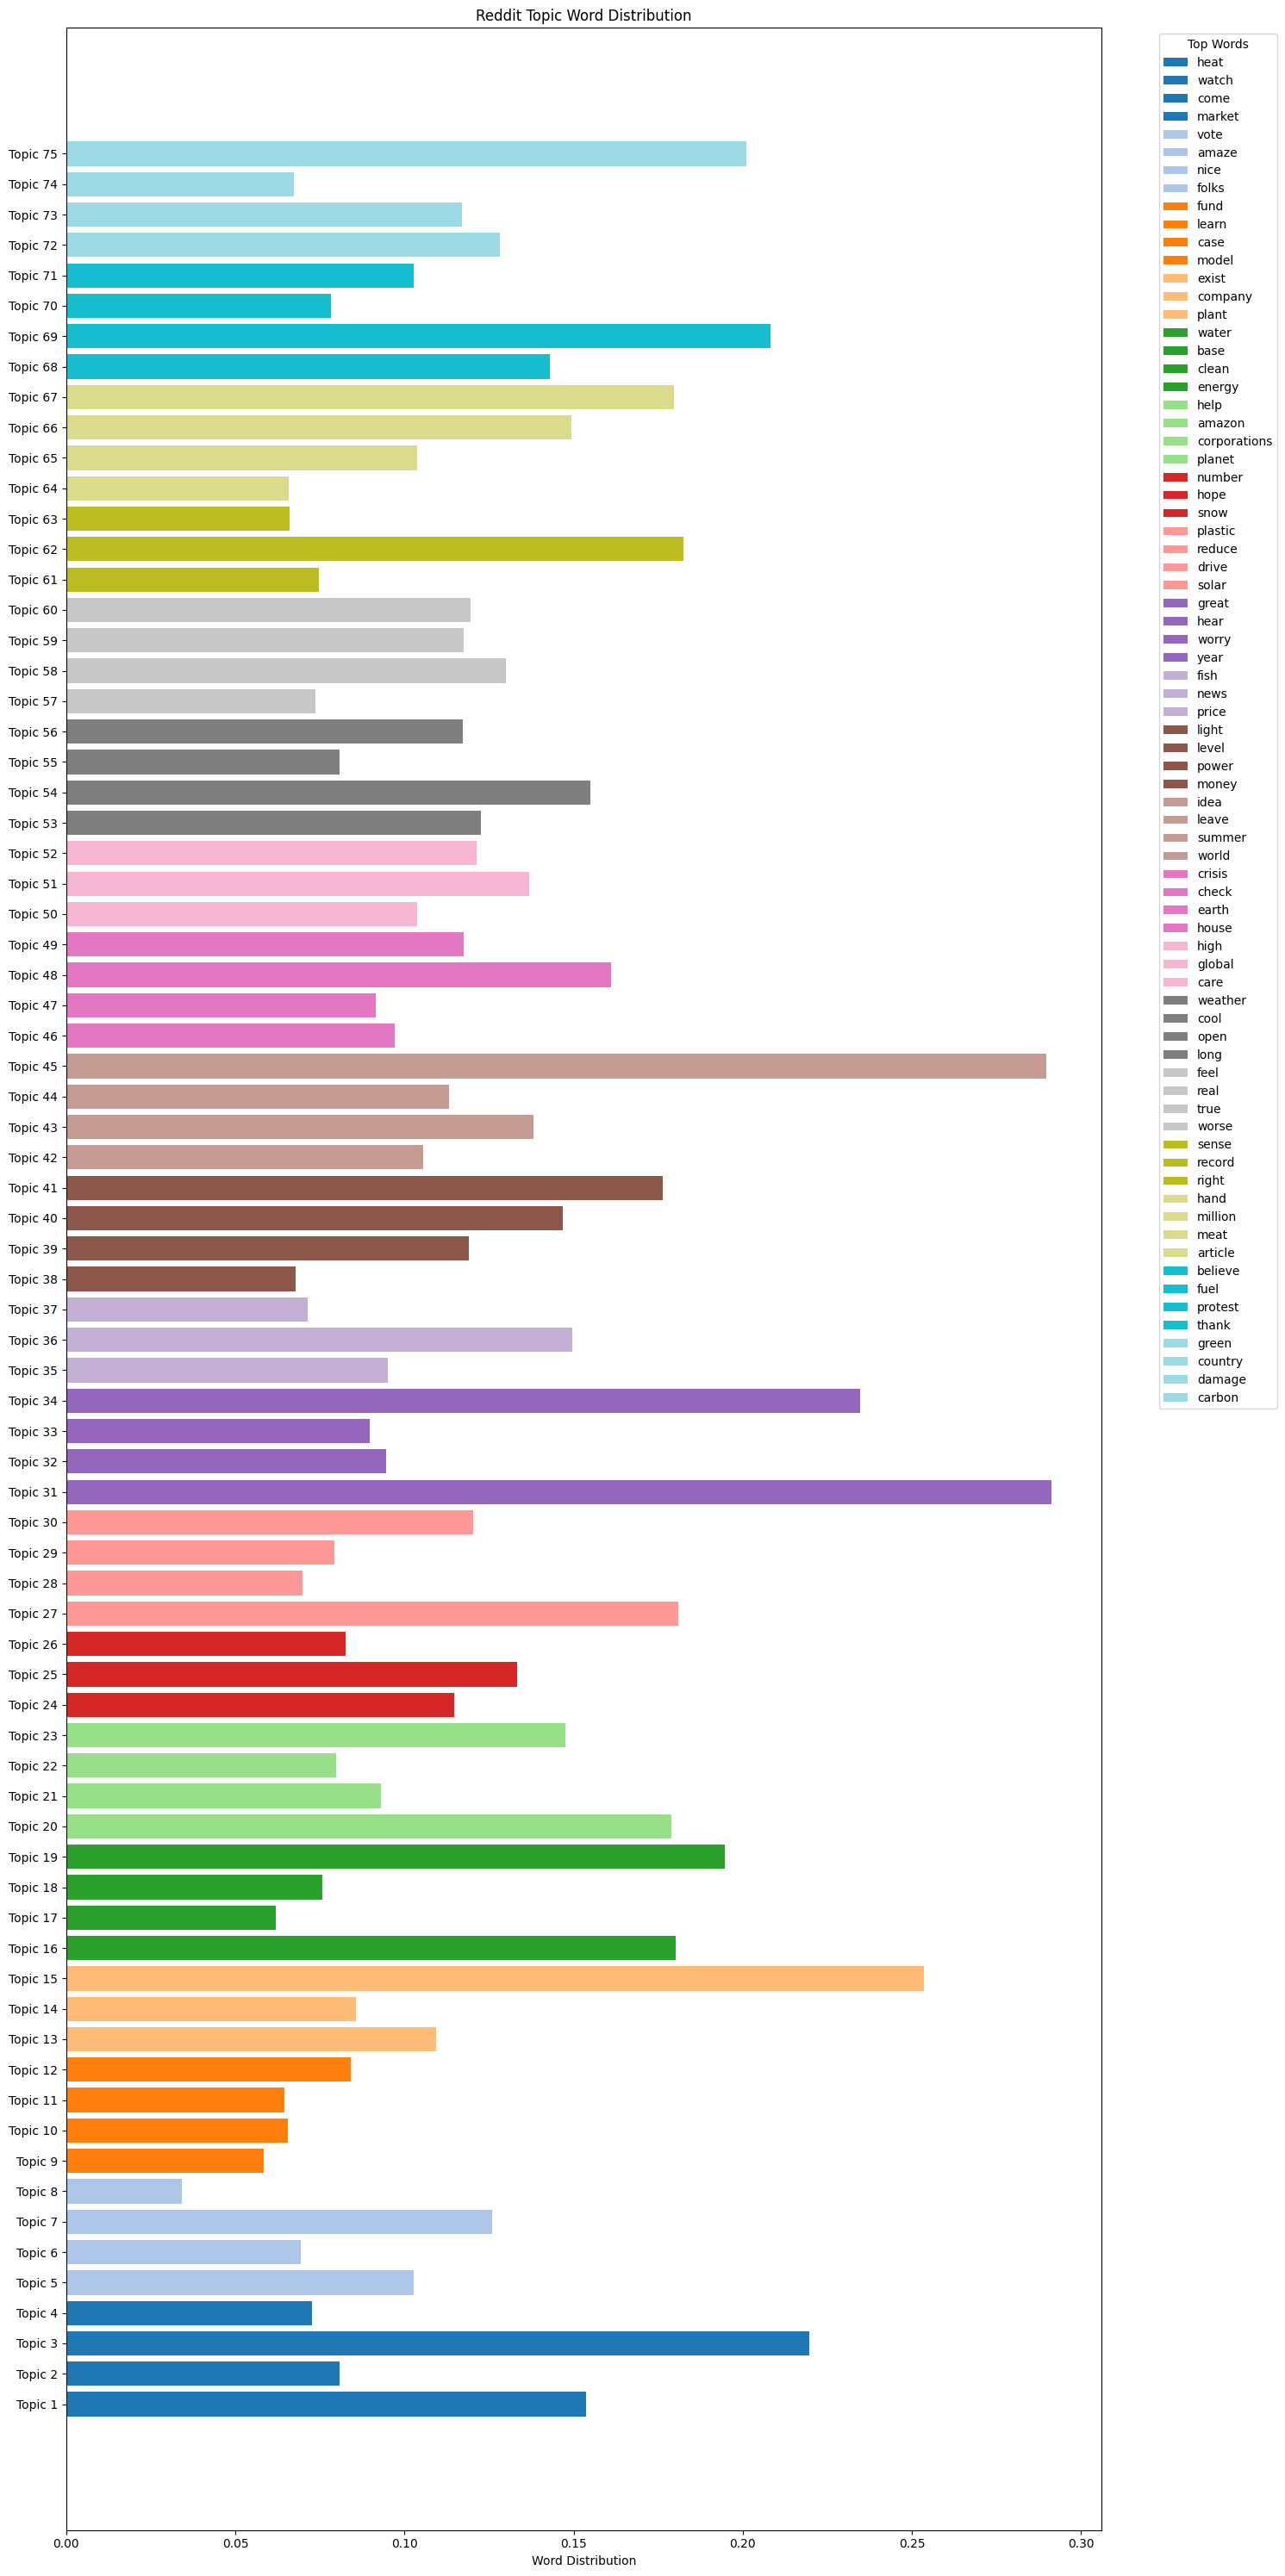

<ipython-input-76-3fbe8846d701>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(topics))  # Use a color map for different topics


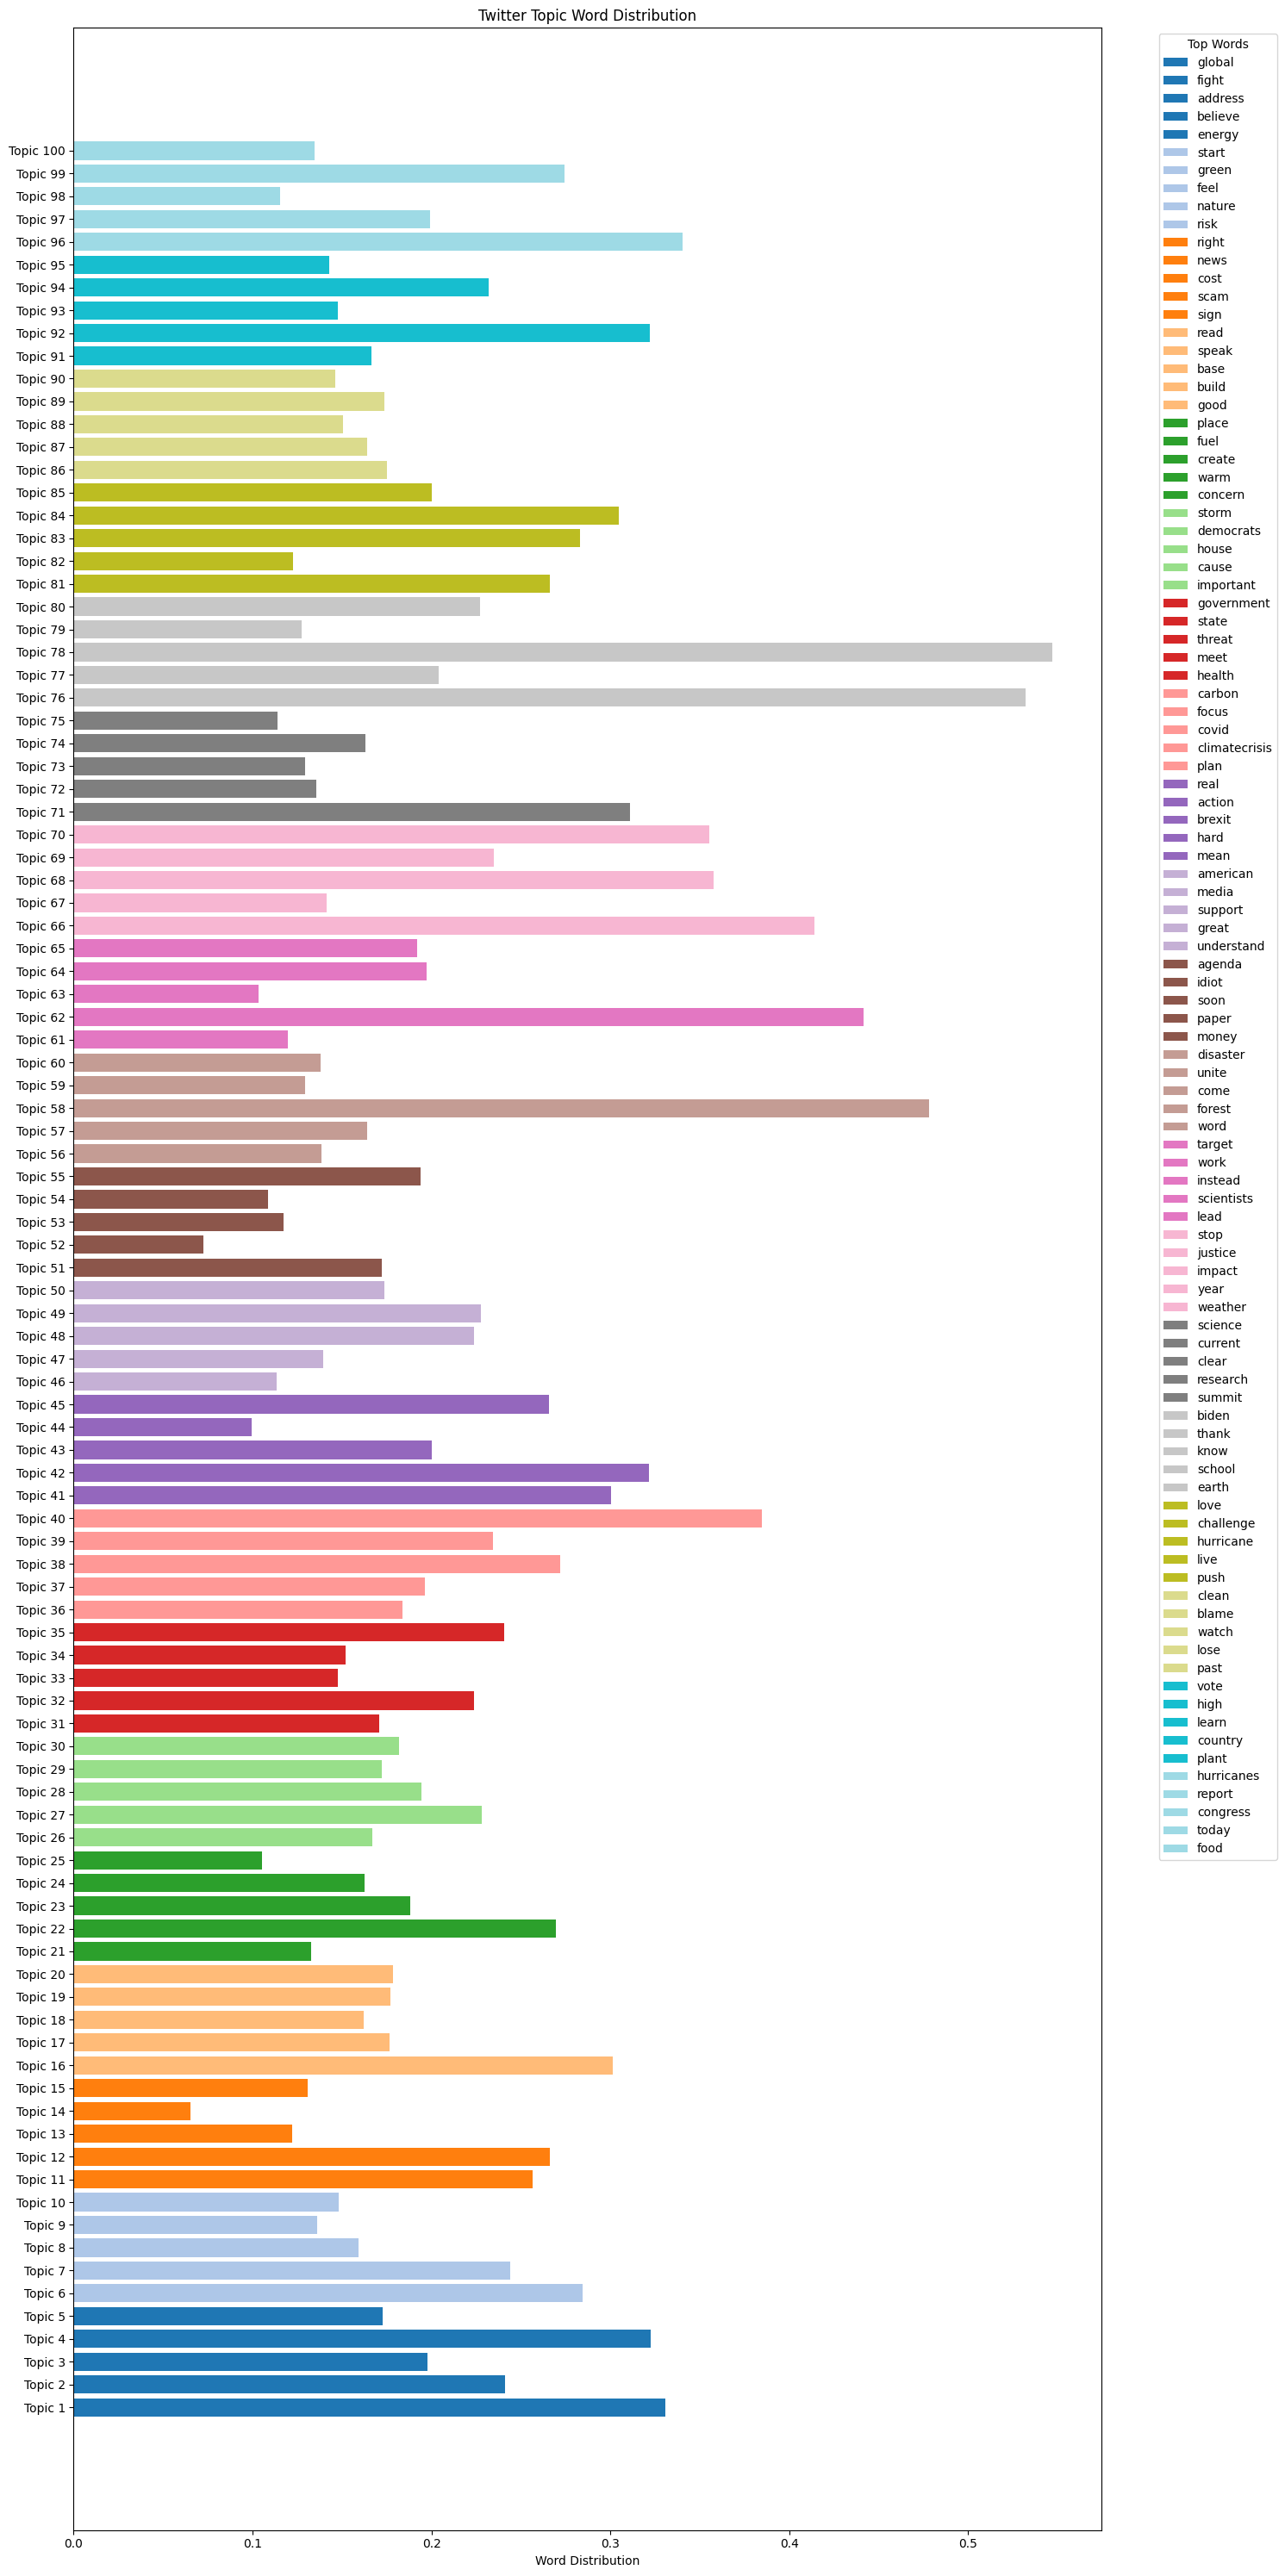

In [ ]:
def plot_topic_word_distributions(model, terms, dataset_name, top_n=1):
    topic_word_distributions = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topics = np.argsort(-topic_word_distributions, axis=1)[:, :top_n]

    data = np.zeros((len(topics), top_n))
    for i, topic in enumerate(topics):
        data[i] = topic_word_distributions[i, topic]

    fig, ax = plt.subplots(figsize=(15, 30))  # adjust size
    ax.barh(range(len(topics)), data.sum(axis=1), color='gray', alpha=0.5)

    colors = plt.cm.get_cmap('tab20', len(topics))  # color map for different topics

    for i, topic in enumerate(topics):
        ax.barh(i, data[i], color=colors(i))
        words = ', '.join([terms[j] for j in topic])
        value = data[i].sum()
        ax.text(value + 0.01, i, words, va='center', fontsize=10, color='black')

    ax.set_title(f'{dataset_name} Topic Word Distribution')
    ax.set_yticks(range(len(topics)))
    ax.set_yticklabels([f'Topic {i+1}' for i in range(len(topics))])

    plt.xlabel('Word Distribution')
    plt.tight_layout()
    plt.show()

plot_topic_word_distributions(best_reddit_model, reddit_terms, dataset_name=names[0], top_n=1)
plot_topic_word_distributions(best_twitter_model, twitter_terms, dataset_name=names[1], top_n=1)

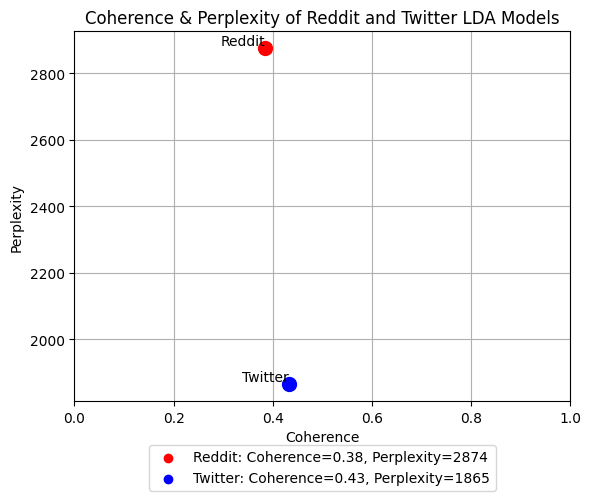

In [ ]:
coherence = [reddit_coherence_score, twitter_coherence_score]
perplexity = [reddit_perplexity, twitter_perplexity]

colors = ['r', 'b']  # Red for Reddit, blue for Twitter

for i in range(len(names)):
    plt.scatter(coherence[i], perplexity[i], color=colors[i], s=100)

    plt.text(coherence[i], perplexity[i], f'{names[i]}',
             fontsize=10, ha='right', va='bottom') # names next to points

plt.xlim(0, 1)  # coherence is contained within [0,1]
plt.xlabel('Coherence')
plt.ylabel('Perplexity')
plt.title('Coherence & Perplexity of Reddit and Twitter LDA Models')

plt.scatter([], [], color='r', label=f'Reddit: Coherence={coherence[0]:.2f}, Perplexity={int(perplexity[0])}')
plt.scatter([], [], color='b', label=f'Twitter: Coherence={coherence[1]:.2f}, Perplexity={int(perplexity[1])}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1) # move legend so it's not on plot

plt.grid(True)
plt.show()

Word Clouds for Top Words in Topics (Reddit vs Twitter)

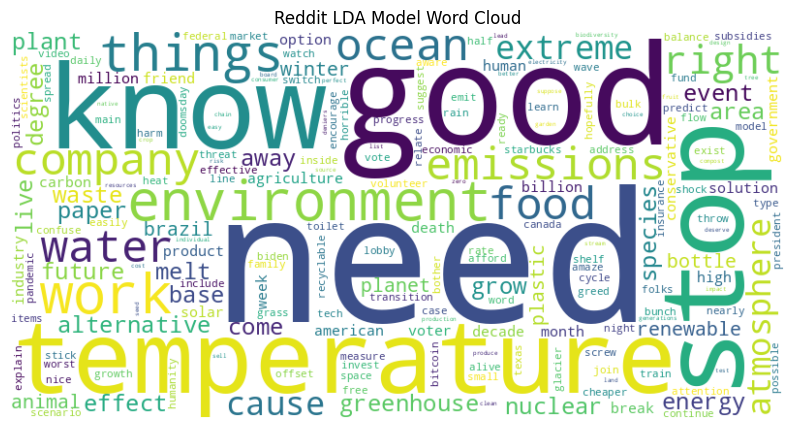

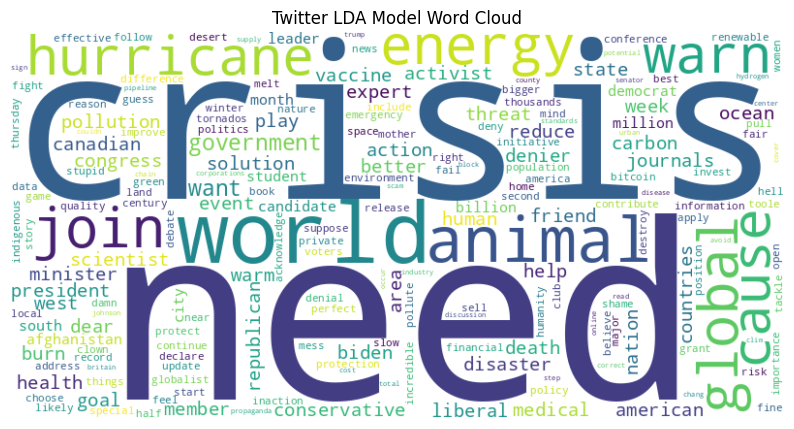

In [ ]:
from wordcloud import WordCloud

def generate_word_cloud(model, terms, top_n=10):
    top_words = [] # select the top top_n words for the word cloud
    for topic in model.components_:
        top_words += [terms[i] for i in topic.argsort()[:-top_n - 1:-1]]

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
    return wordcloud

reddit_wordcloud = generate_word_cloud(best_reddit_model, reddit_terms, top_n=10)
plt.figure(figsize=(10, 6))
plt.imshow(reddit_wordcloud, interpolation='bilinear')
plt.title('Reddit LDA Model Word Cloud')
plt.axis('off')
plt.show()

twitter_wordcloud = generate_word_cloud(best_twitter_model, twitter_terms, top_n=10)
plt.figure(figsize=(10, 6))
plt.imshow(twitter_wordcloud, interpolation='bilinear')
plt.title('Twitter LDA Model Word Cloud')
plt.axis('off')
plt.show()

Heatmap of Document-Topic Distributions

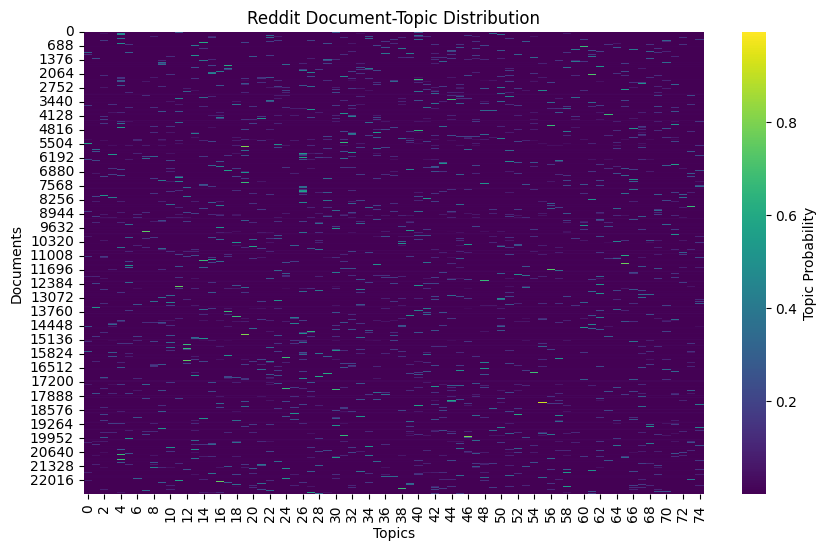

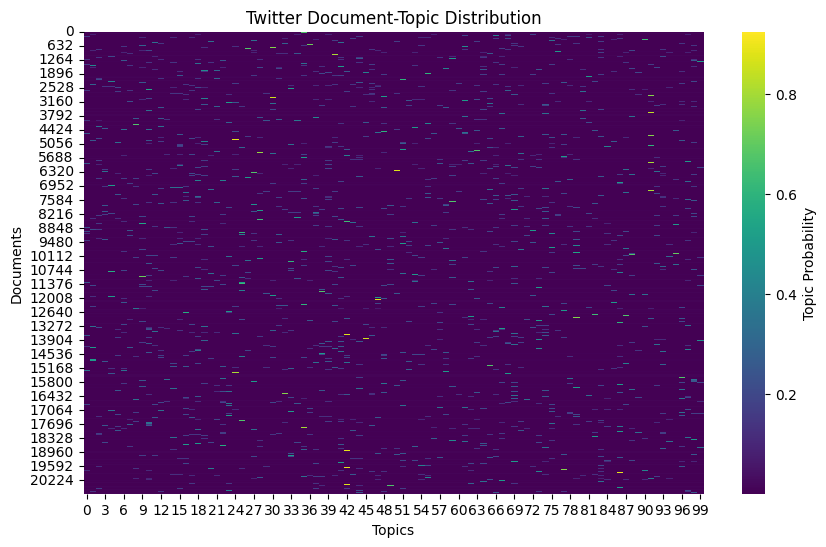

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(reddit_topic_distribution, cmap='viridis', cbar_kws={'label': 'Topic Probability'})
plt.title('Reddit Document-Topic Distribution')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(twitter_topic_distribution, cmap='viridis', cbar_kws={'label': 'Topic Probability'})
plt.title('Twitter Document-Topic Distribution')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.show()